In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Cargar el archivo CSV
df = pd.read_csv('omar2024.csv', 
                 sep=';',  # Especificamos el separador como punto y coma
                 encoding='utf-8',  # Encoding típico para archivos de AFIP
                 decimal=',',  # Especificamos la coma como separador decimal
                 thousands='.',  # Especificamos el punto como separador de miles
)

In [10]:
df.head()

,Fecha de Emisión,Tipo de Comprobante,Punto de Venta,Número Desde,Número Hasta,Cód. Autorización,Tipo Doc. Receptor,Nro. Doc. Receptor,Denominación Receptor,Tipo Cambio,Moneda,Imp. Neto Gravado,Imp. Neto No Gravado,Imp. Op. Exentas,Otros Tributos,IVA,Imp. Total
0,2024-01-16,11,4,54,54,74031522188887,80,27313608110,COSTA ANKENBRAND MARIA DANIELA,1.0,PES,0.0,0.0,0.0,0.0,0.0,102328.15
1,2024-01-16,11,4,55,55,74031522807323,80,27313608110,COSTA ANKENBRAND MARIA DANIELA,1.0,PES,0.0,0.0,0.0,0.0,0.0,58208.75
2,2024-01-19,11,3,1360,1360,74031526708627,96,18249668,GORLERI HORACIO GUSTAVO CEFERINO,1.0,PES,0.0,0.0,0.0,0.0,0.0,52974.55
3,2024-01-19,11,3,1366,1366,74031529251636,80,20201012490,SFEIR PABLO,1.0,PES,0.0,0.0,0.0,0.0,0.0,26400.00
4,2024-01-19,11,3,1361,1361,74031527084726,80,20332251989,ALVAREZ SERGIO JAVIER,1.0,PES,0.0,0.0,0.0,0.0,0.0,4431.20


In [12]:
df.columns

Index(['Fecha de Emisión', 'Tipo de Comprobante', 'Punto de Venta',
       'Número Desde', 'Número Hasta', 'Cód. Autorización',
       'Tipo Doc. Receptor', 'Nro. Doc. Receptor', 'Denominación Receptor',
       'Tipo Cambio', 'Moneda', 'Imp. Neto Gravado', 'Imp. Neto No Gravado',
       'Imp. Op. Exentas', 'Otros Tributos', 'IVA', 'Imp. Total'],
      dtype='object')

In [15]:
# Seleccionamos solo las columnas requeridas
columnas_requeridas = [
    'Fecha de Emisión', 
    'Punto de Venta',
    'Número Desde', 
    'Número Hasta', 
    'Nro. Doc. Receptor', 
    'Denominación Receptor', 
    'Imp. Total'
]

df = df[columnas_requeridas]

In [16]:
df.columns

Index(['Fecha de Emisión', 'Punto de Venta', 'Número Desde', 'Número Hasta',
       'Nro. Doc. Receptor', 'Denominación Receptor', 'Imp. Total'],
      dtype='object')

In [25]:
df['Fecha de Emisión'].head()

0   2024-01-16
1   2024-01-16
2   2024-01-19
3   2024-01-19
4   2024-01-19
Name: Fecha de Emisión, dtype: datetime64[ns]

In [24]:
df['Fecha de Emisión'] = pd.to_datetime(df['Fecha de Emisión'], format='%Y-%m-%d')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Fecha de Emisión       215 non-null    datetime64[ns]
 1   Punto de Venta         215 non-null    int64         
 2   Número Desde           215 non-null    int64         
 3   Número Hasta           215 non-null    int64         
 4   Nro. Doc. Receptor     215 non-null    int64         
 5   Denominación Receptor  215 non-null    object        
 6   Imp. Total             215 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 11.9+ KB


In [27]:
# Agrupamos por mes y sumamos el Imp. Total
facturacion_mensual = df.groupby(df['Fecha de Emisión'].dt.to_period('M'))['Imp. Total'].sum().reset_index()
facturacion_mensual['Fecha de Emisión'] = facturacion_mensual['Fecha de Emisión'].dt.to_timestamp()

# Calculamos la facturación acumulada
facturacion_mensual['Acumulado'] = facturacion_mensual['Imp. Total'].cumsum()

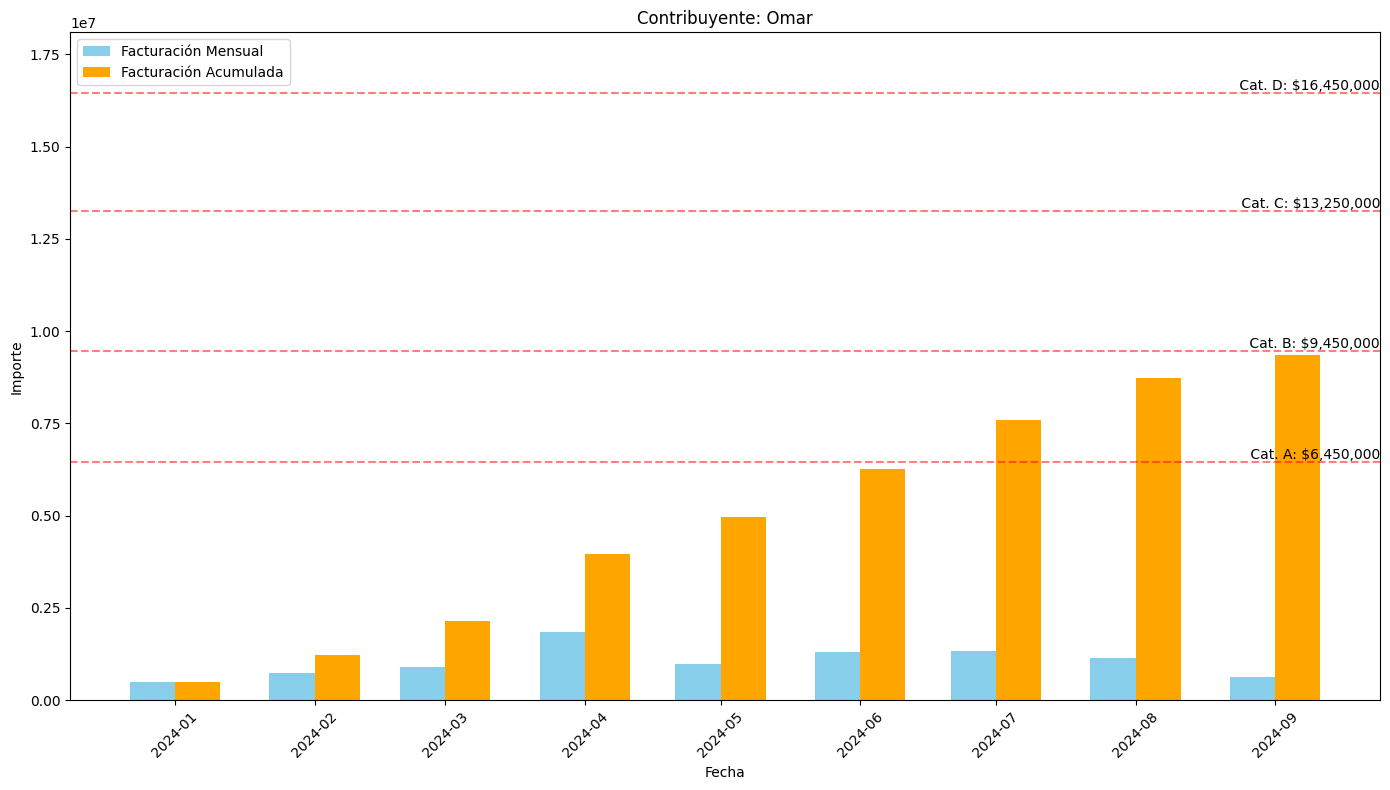

In [32]:
# Agrupamos por mes y sumamos el Imp. Total
facturacion_mensual = df.groupby(df['Fecha de Emisión'].dt.to_period('M'))['Imp. Total'].sum().reset_index()
facturacion_mensual['Fecha de Emisión'] = facturacion_mensual['Fecha de Emisión'].dt.to_timestamp()

# Calculamos la facturación acumulada
facturacion_mensual['Acumulado'] = facturacion_mensual['Imp. Total'].cumsum()

# Definimos las categorías de monotributo
categorias = {
    'A': 6450000, 'B': 9450000, 'C': 13250000, 'D': 16450000, 
    'E': 19350000, 'F': 24250000, 'G': 29000000, 'H': 44000000, 
    'I': 49250000, 'J': 56400000, 'K': 68000000
}

# Función para obtener las categorías relevantes
def obtener_categorias_relevantes(facturacion_max):
    cat_relevantes = {}
    categorias_ordenadas = sorted(categorias.items(), key=lambda x: x[1])
    categoria_actual = next((cat for cat, valor in categorias_ordenadas if valor > facturacion_max), 'K')
    indice_actual = next(i for i, (cat, _) in enumerate(categorias_ordenadas) if cat == categoria_actual)
    
    # Incluimos todas las categorías por debajo de la actual
    for cat, valor in categorias_ordenadas[:indice_actual]:
        cat_relevantes[cat] = valor
    
    # Incluimos la categoría actual y las dos siguientes (si existen)
    for i in range(indice_actual, min(indice_actual + 3, len(categorias_ordenadas))):
        cat, valor = categorias_ordenadas[i]
        cat_relevantes[cat] = valor
    
    return cat_relevantes

# Obtenemos la facturación máxima acumulada
facturacion_max = facturacion_mensual['Acumulado'].max()

# Obtenemos las categorías relevantes
categorias_relevantes = obtener_categorias_relevantes(facturacion_max)

# Creamos el gráfico
fig, ax = plt.subplots(figsize=(14, 8))

# Configuramos el ancho de las barras y la posición
width = 10  # Ancho de cada barra en días
x = facturacion_mensual['Fecha de Emisión']

# Barras para facturación mensual
ax.bar(x - pd.Timedelta(days=width/2), facturacion_mensual['Imp. Total'], 
       width=width, label='Facturación Mensual', color='skyblue')

# Barras para facturación acumulada
ax.bar(x + pd.Timedelta(days=width/2), facturacion_mensual['Acumulado'], 
       width=width, label='Facturación Acumulada', color='orange')

# Añadimos las líneas horizontales para cada categoría relevante
for categoria, valor in categorias_relevantes.items():
    ax.axhline(y=valor, color='red', linestyle='--', alpha=0.5)
    ax.text(ax.get_xlim()[1], valor, f' Cat. {categoria}: ${valor:,}', 
            verticalalignment='bottom', horizontalalignment='right')

# Configuración del gráfico
ax.set_xlabel('Fecha')
ax.set_ylabel('Importe')
ax.set_title('Contribuyente: Omar')
ax.legend()

# Rotamos las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Ajustamos el límite superior del eje y para dar espacio a todas las categorías relevantes
ax.set_ylim(top=max(categorias_relevantes.values()) * 1.1)

# Ajustamos el diseño y mostramos el gráfico
plt.tight_layout()
plt.show()
